In [301]:
import numpy as np
import cv2

In [302]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
import os

In [303]:
def read_dataset(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        
        if img is not None:
            img = cv2.resize(img,(64,64))
            images.append(img)
    return images

In [304]:
images = read_dataset('data/all-mias/')
images.extend(read_dataset('data/dental'))
len(images)

442

In [305]:
len(images[0])

64

In [306]:
images = np.array(images)
print images.shape

(442, 64, 64)


In [307]:
images = images.astype('float32')/255.
images = np.reshape(images, (images.shape[0],64,64,1))

In [308]:
images.shape

(442, 64, 64, 1)

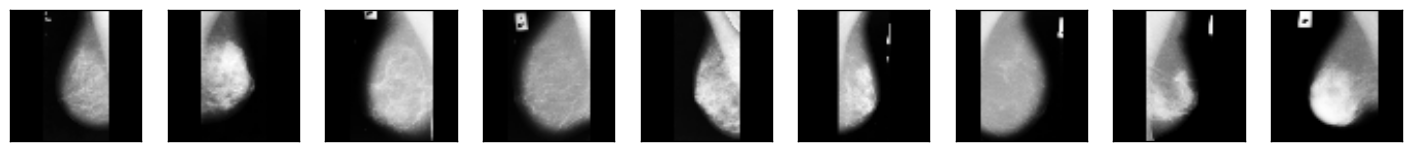

In [309]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [310]:
#adding noise
def salt_and_pepper(image,factor):
    noise_factor = factor
    
    x_train_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [311]:
def gaussian_noise(x_train,mean,sigma,proportion):    
    x_train_noisy = []
    for i in range(x_train.shape[0]):
        image = x_train[i]
        noise = proportion*np.random.normal(mean,sigma,x_train[0].shape)
        x_train_noisy.append(image + noise)
     
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

In [312]:
def poisson_noise(x_train):
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='poisson', seed=None, clip=True)    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_test_noisy

In [313]:
def gamma_noise(x_train,shape,scale=1.0):
    
    row,col,ch = x_train[0].shape
    
    x_train_noisy = x_train + np.random.gamma(shape,scale,x_train.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

In [314]:
x_test.shape

(72, 64, 64, 1)

In [106]:
x_train_noisy,x_test_noisy = salt_and_pepper(x_train,x_test,0.5)

In [165]:
x_train_noisy,x_test_noisy = gaussian_noise(x_train,x_test,0,1,0.1)

In [189]:
x_train_noisy = gamma_noise(images,1,1)

In [90]:
x_train_noisy,x_test_noisy = poisson_noise(x_train,x_test)

In [315]:
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = images.shape[0]/4;
    noise1 = gaussian_noise(images[0:batch],0,1,0.1)
    noise2 = gaussian_noise(images[batch:2*batch],0,1,0.5)
    noise3 = gaussian_noise(images[2*batch:3*batch],0,2,0.2)
    noise4 = gaussian_noise(images[3*batch:],0,5,0.2)
    
    noisy_set = []
    for data in [noise1,noise2,noise3,noise4]:
        for image in data:
            noisy_set.append(image)
    
    return noisy_set
    
    
    

In [321]:
from random import shuffle
shuffle(images)

In [322]:
noisy_set = add_noise(images)

In [323]:
noisy_set = np.array(noisy_set)
print noisy_set.shape

(442, 64, 64, 1)


In [324]:
x_train = images[0:350]
x_train_noisy = noisy_set[0:350]
x_test = images[350:]
x_test_noisy = noisy_set[350:]
print x_train_noisy.shape
print x_test_noisy.shape

(350, 64, 64, 1)
(92, 64, 64, 1)


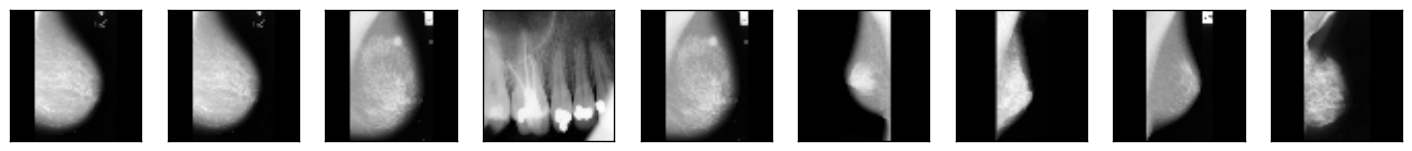

In [340]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [326]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard


In [327]:
input_img = Input(shape=x_train_noisy[0].shape)  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 32, 32, 64)        0         
__________

In [328]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=True)])

Train on 350 samples, validate on 92 samples
Epoch 1/50
350/350 [==============================] - 17s - loss: 0.4714 - val_loss: 0.3783
Epoch 2/50
350/350 [==============================] - 15s - loss: 0.2955 - val_loss: 0.3075
Epoch 3/50
350/350 [==============================] - 16s - loss: 0.2864 - val_loss: 0.3155
Epoch 4/50
350/350 [==============================] - 16s - loss: 0.2798 - val_loss: 0.3076
Epoch 5/50
350/350 [==============================] - 14s - loss: 0.2756 - val_loss: 0.3152
Epoch 6/50
350/350 [==============================] - 14s - loss: 0.2740 - val_loss: 0.3055
Epoch 7/50
350/350 [==============================] - 15s - loss: 0.2746 - val_loss: 0.3056
Epoch 8/50
350/350 [==============================] - 16s - loss: 0.2716 - val_loss: 0.3360
Epoch 9/50
350/350 [==============================] - 17s - loss: 0.2715 - val_loss: 0.3090
Epoch 10/50
350/350 [==============================] - 17s - loss: 0.2678 - val_loss: 0.3119
Epoch 11/50
350/350 [=============

In [341]:
out = autoencoder.predict(x_test_noisy,verbose=1)

92/92 [==============================] - 1s     


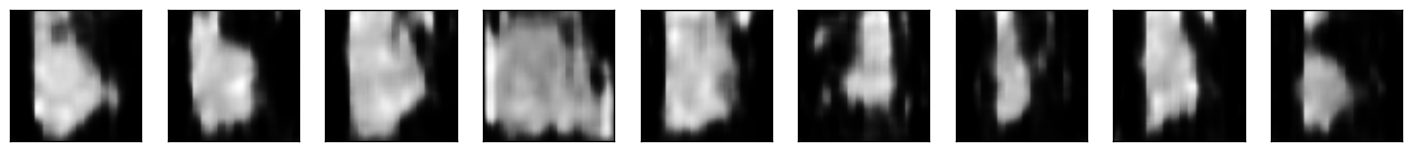

In [342]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(out[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [332]:
x_test.shape

(92, 64, 64, 1)

In [333]:
import math
def mse(x, y):
    return np.linalg.norm(x - y)

def get_mse(imageA,imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [334]:
def get_psnr(imageA,imageB):
    maxI = 1
    try:
        return 20*math.log10(maxI) - 10*math.log10(get_mse(imageA,imageB))
    except:
        return 20*math.log10(maxI)

In [335]:
def get_result(x_test, out):
    psnr_sum = 0
    for i in range(out.shape[0]):
        psnr_sum += get_psnr(x_test[i],out[i])
    return 1.0*psnr_sum/out.shape[0];

In [336]:
get_result(x_test,out)

19.813387832175767

In [337]:
get_result(x_test_noisy,x_test)

6.31856237865672

In [377]:
def nlm_denoising(x_test_noisy):
    denoised=[]
    for image in x_test_noisy:
        img = image.reshape(64,64)
        dno = np.array(img)
        print img
        cv2.fastNlMeansDenoising(img,dno)
        denoised.append(dno)
    return denoised

In [378]:
nlm_denoise = nlm_denoising(x_test_noisy)

[[ 0.          0.          0.52935386 ...,  0.          0.          0.2000892 ]
 [ 0.86319143  0.99152056  0.67480974 ...,  0.          0.          0.        ]
 [ 1.          0.22821643  0.         ...,  0.          0.          1.        ]
 ..., 
 [ 0.50633392  0.22317152  0.         ...,  0.5247978   0.85359067
   0.53827305]
 [ 1.          0.          0.84019415 ...,  0.41574204  0.          1.        ]
 [ 0.58280236  0.          1.         ...,  0.13434104  0.91288096
   0.18206116]]


error: /build/opencv-SviWsf/opencv-2.4.9.1+dfsg/modules/photo/src/denoising.cpp:78: error: (-5) Unsupported image format! Only CV_8UC1, CV_8UC2 and CV_8UC3 are supported in function fastNlMeansDenoising


In [347]:
image = cv2.imread('data/two',0)

In [379]:
image = np.resize(image,(64,64))
denoised=np.array(image)
print image
cv2.fastNlMeansDenoising(image,denoised)
cv2.imshow('tt',image)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
